# MLE tutorial from 
https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f

## Setup
MLE is easy if you import the right packages:

In [11]:
# import libraries
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import pymc3 as pm3
import numdifftools as ndt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

From there, we will generate data that follows a normally distributed errors around a ground truth function:

In [24]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1
df[:5]

,y,x,constant
0,-6.861127,0.000000,1
1,-2.320489,0.202020,1
2,4.361313,0.404040,1
3,7.328508,0.606061,1
4,3.053775,0.808081,1


Finally, let’s visualize using Seaborn’s regplot:
Keep in mind there’s randomness here and we didn’t use a seed:

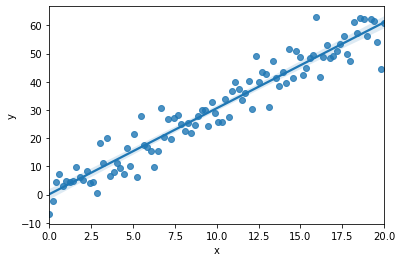

In [25]:
# plot
sns.regplot(df.x, df.y);

## Modeling OLS with Statsmodels
Since we created regression-like, continuous data, we will use sm.OLS to calculate the best coefficients and Log-likelihood (LL) as a benchmark.

In [27]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     1216.
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           4.75e-57
Time:                        14:42:30   Log-Likelihood:                -303.73
No. Observations:                 100   AIC:                             611.5
Df Residuals:                      98   BIC:                             616.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.1348      1.012      0.133      0.894      -1.873       2.142
x              3.0475      0.087     34.874      0.000       2.874       3.221
==============================================================================
Omnibus:                        1.570   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.456   Jarque-Bera (JB):                1.066
Skew:                           0.049   Prob(JB):                        0.587
Kurtosis:                       3.496   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice constant is close to zero, and beta for feature x is close to 3, per the ground truth generator we used.

## Maximizing LL to solve for Optimal Coefficients
From here, we’ll use a combination of packages and custom functions to see if we can calculate the same OLS results above using MLE methods.
Because scipy.optimize has only a minimize method, we'll minimize the negative of the log-likelihood. This is even what they recommend! Math trickery is often faster and easier than re-inventing the wheel!
We can build a simple function that does everything in one pass for regression outputs:

In [28]:
# define likelihood function
def MLERegression(params):
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
    # return negative LL
    return(negLL)

Now that we have a cost function, let’s initialize and minimize it:


In [30]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
 options={'disp': True})

Optimization terminated successfully.
         Current function value: 303.728816
         Iterations: 103
         Function evaluations: 191


Let’s check the results:

In [31]:
results # this gives us verbosity around our minimization
# notice our final key and associated values…

 final_simplex: (array([[0.13484299, 3.04755201, 5.04476557],
       [0.13491245, 3.04754289, 5.04477105],
       [0.134771  , 3.04755255, 5.04473284],
       [0.1348898 , 3.04754971, 5.04474422]]), array([303.72881563, 303.72881563, 303.72881563, 303.72881563]))
           fun: 303.7288156283786
       message: 'Optimization terminated successfully.'
          nfev: 191
           nit: 103
        status: 0
       success: True
             x: array([0.13484299, 3.04755201, 5.04476557])

And we can clean up further:

In [32]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf.head(2), 4)

,coef
constant,0.1348
x,3.0476


You’ll note that OLS and MLE match up nicely! Your results will differ, again, as we’re not using random seeds.

# Best Practices for MLE
Before we go any further, this might be a good moment to reinforce our trust in MLE. As our regression baseline, we know that Ordinary Least Squares — by definition — is the best linear unbiased estimator for continuous outcomes that have normally distributed residuals and meet the other assumptions of linear regression. Is using MLE to find our coefficients as robust?
## Yes!
MLE is consistent with OLS.
With infinite data, it will estimate the optimal β, and approximate it well for small but robust datasets.
MLE is efficient; no consistent estimator has lower asymptotic mean squared error than MLE.
So it looks like it fully replicates what OLS does. Then… why use MLE instead of OLS?
## Because!
MLE is generalizable for regression and classification!
MLE is efficient; no consistent estimator has lower asymptotic error than MLE if you’re using the right distribution.
We can think of MLE as a modular way of fitting models by optimizing a probabilistic cost function!
## Four major steps in applying MLE:
Define the likelihood, ensuring you’re using the correct distribution for your regression or classification problem.
Take the natural log and reduce the product function to a sum function.
Maximize — or minimize the negative of — the objective function.
Verify that uniform priors are a safe assumption! Otherwise, you could attribute the data to a generating function or model of the world that fails the Law of Parsimony.
There’s much more in the MLE space, including categorical distributions, using Bayesian statistics packages like PyMC3 , etc. But we’ll stop here for today.